In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from collections import OrderedDict
from textwrap import wrap

In [3]:
df = pd.read_json('./Data/db_export.csv', encoding='ISO-8859-1')
df.info()
df.head()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 21 columns):
1_1                      58 non-null int64
1_2                      58 non-null int64
1_3                      58 non-null int64
1_4                      58 non-null int64
1_5                      58 non-null int64
1_6                      58 non-null object
2_1                      58 non-null object
2_2                      58 non-null int64
2_3                      58 non-null int64
2_4                      58 non-null int64
3_1                      58 non-null int64
3_2                      58 non-null int64
3_3                      58 non-null int64
3_4                      58 non-null int64
3_5                      58 non-null int64
3_6                      58 non-null int64
3_7                      58 non-null int64
computerButtonClicked    58 non-null int64
email                    58 non-null object
themeChosen              58 non-null int64
timeToComplete           58 non-nu

,1_1,1_2,1_3,1_4,1_5,1_6,2_1,2_2,2_3,2_4,...,3_2,3_3,3_4,3_5,3_6,3_7,computerButtonClicked,email,themeChosen,timeToComplete
0,2,1,1,2,2,"[1, 2, 4, 5]","[1, 7]",1,2,2,...,4,3,4,3,2,1,0,tlkramer@smu.edu,3,51.131
1,1,1,1,1,1,"[1, 3, 4, 5, 6]",[5],2,2,2,...,4,3,4,3,2,1,0,dcsanchez@smu.edu,1,317.141
2,2,1,1,2,2,"[1, 2, 4, 5]",[5],1,2,2,...,3,2,3,2,3,1,0,ccjohnson@smu.edu,1,179.159
3,1,1,1,2,3,"[1, 2, 4]",[7],1,2,2,...,4,3,4,3,3,1,0,awoodruff@smu.edu,2,84.053
4,1,1,2,3,3,"[1, 2, 4, 5]","[1, 4]",1,2,2,...,4,3,4,1,1,1,0,chalquist@smu.edu,3,73.996


First, we'll need to extract the questions and their choices from the webpage

In [4]:
# open the webpage to parse for questions
with open ('./../AB-Testing-Form/templates/index.phtml') as fp:
    soup = BeautifulSoup(fp, 'html.parser')

In [5]:
survey_questions = {}  # question : [choices]

In [6]:
# for each page in the form
pages = soup.find_all('div', class_='page')
for p in range(len(pages)):
    
    if p > 0:  # ignore the first page
        questions = pages[p].find_all('div', class_='row section')
        
        for q in questions:
            # strip the number from the question
            question_title = q.find('h5').contents[1]
            
            # option tags surrounding the choices
            options = q.find('div', class_="input-field col s12 m8"
                            ).find('select').find_all('option')
            
            choices = []
            
            # keep track of those choices that aren't disabled
            for o in options:
                if 'disabled' not in str(o):
                    choices.append(o.contents[0])

            survey_questions[question_title] = choices 

In [7]:
# list of dictionaries containing responses and their occurrences
responses = []

df_questions = df

cols_to_remove = 4

# remove those instances that weren't completed
if 'dropout' in df.columns:
    df_questions = df[df.dropout != 'true']
    cols_to_remove += 2
    
# remove non-questions from the data
df_questions = df_questions.iloc[:, :-cols_to_remove]  
print(len(df_questions.columns))
for column in df_questions:
    col = df_questions[column]
    
    # questions with one option
    if col.dtype == "int64":
        responses.append(dict(sorted(Counter(col).items())))
    else:  # questions with multiple values
        # join the responses
        combined_responses = [int(inner) for outer in col 
                              for inner in outer]
        responses.append(dict(sorted(Counter(combined_responses).items())))

17


In [8]:
responses

[{1: 42, 2: 15, 3: 1},
 {1: 37, 2: 21},
 {1: 52, 2: 6},
 {1: 12, 2: 38, 3: 8},
 {1: 22, 2: 28, 3: 8},
 {1: 58, 2: 41, 3: 19, 4: 51, 5: 55, 6: 7},
 {1: 22, 3: 4, 4: 17, 5: 21, 7: 2},
 {1: 48, 2: 9, 3: 1},
 {1: 15, 2: 43},
 {1: 21, 2: 29, 3: 6, 4: 2},
 {1: 2, 2: 11, 3: 24, 4: 21},
 {2: 3, 3: 16, 4: 39},
 {2: 5, 3: 53},
 {2: 3, 3: 7, 4: 48},
 {1: 14, 2: 11, 3: 33},
 {1: 6, 2: 20, 3: 22, 4: 10},
 {1: 56, 2: 1, 3: 1}]

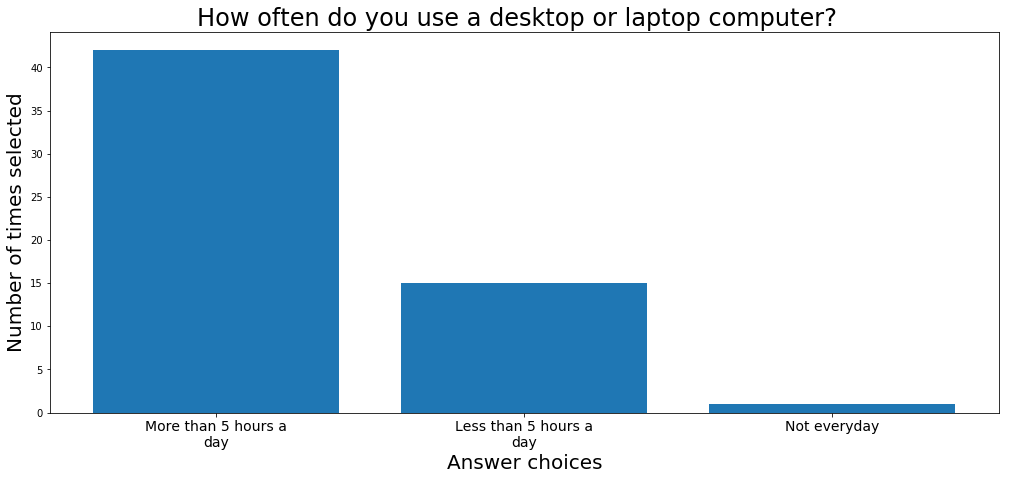

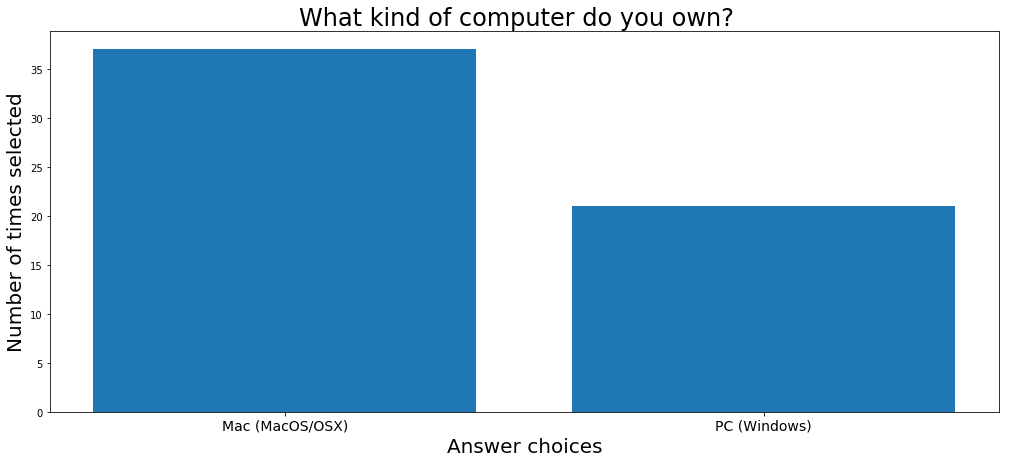

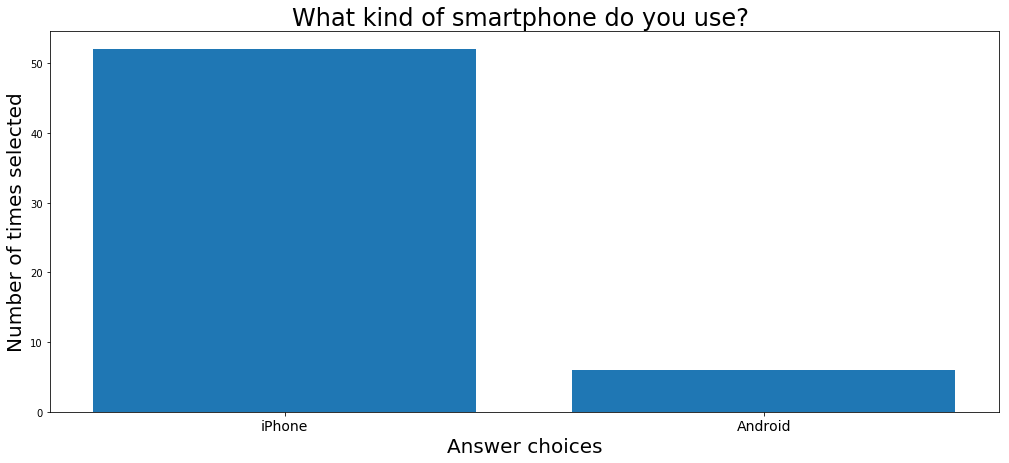

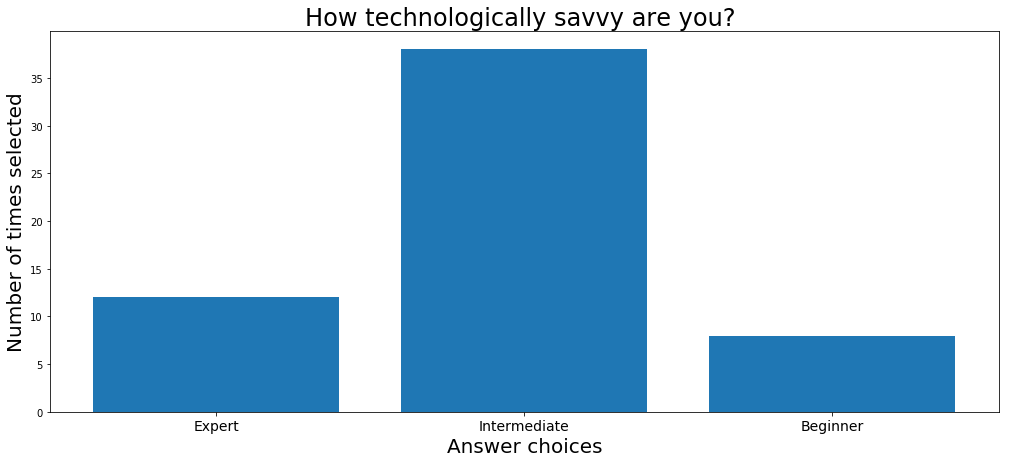

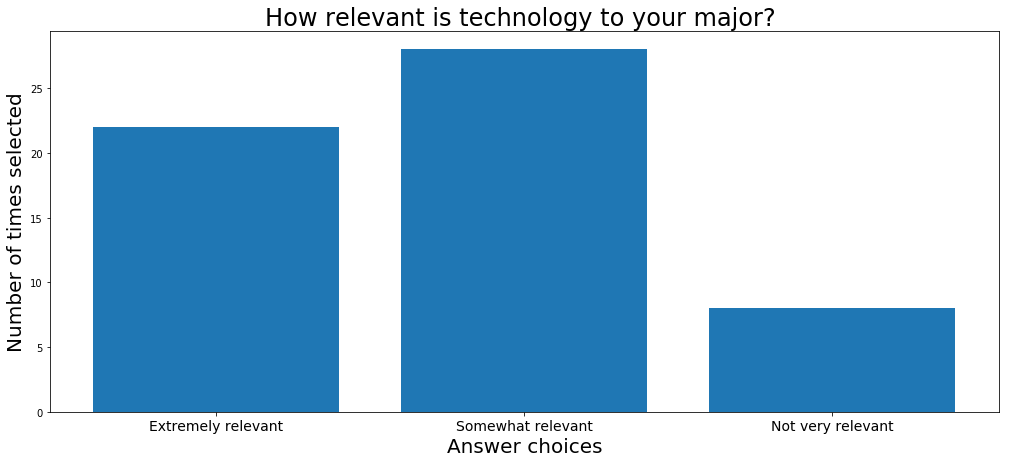

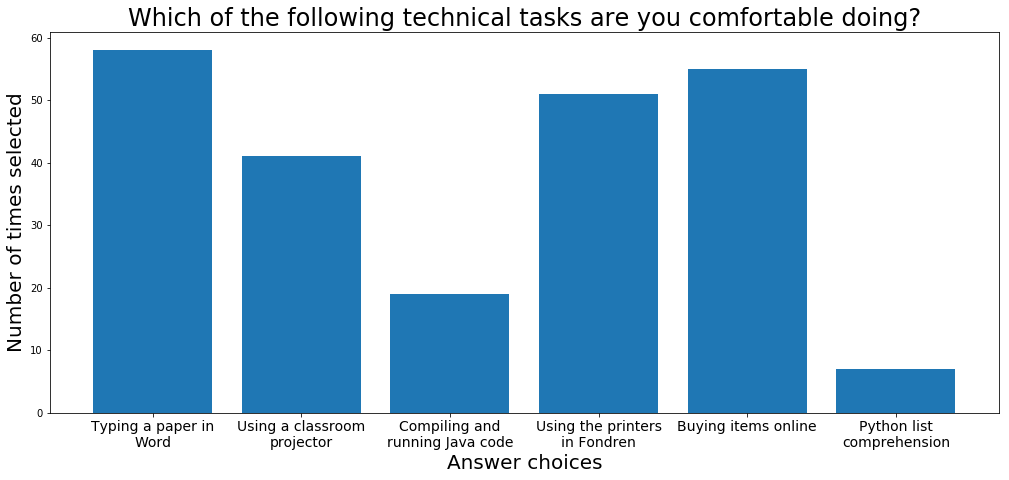

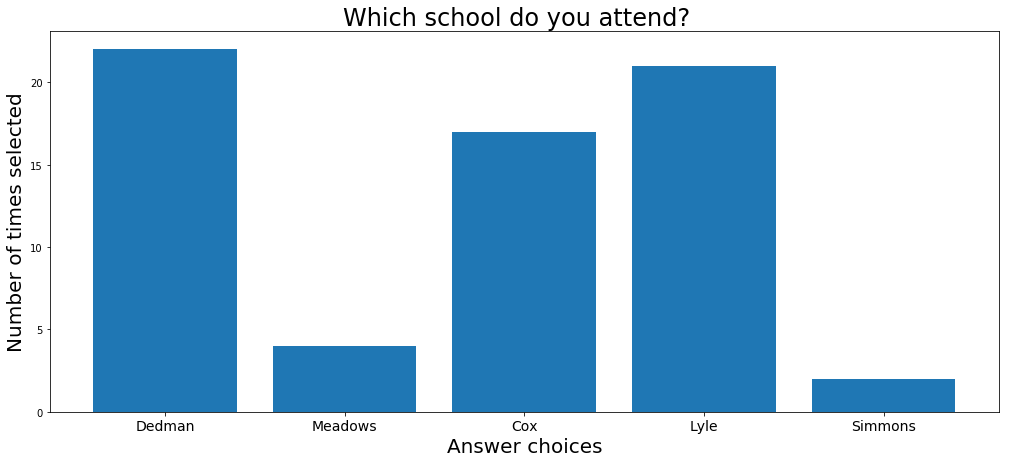

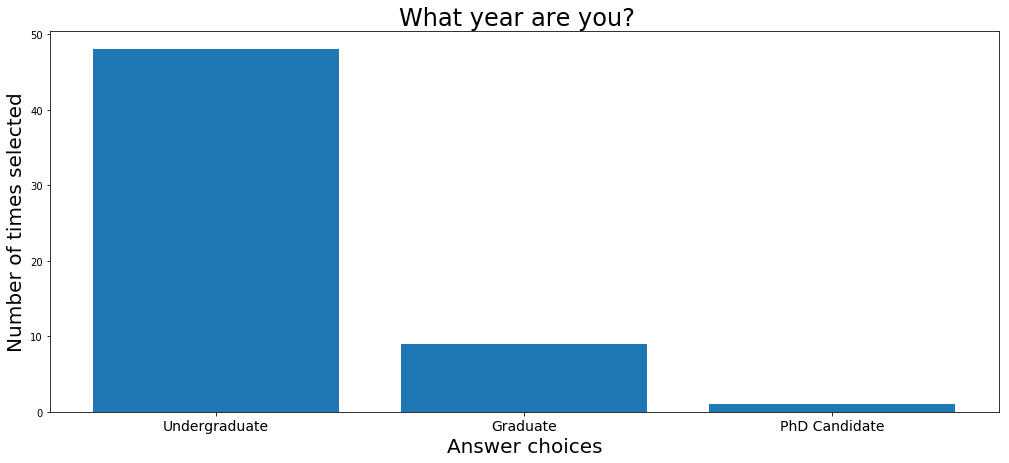

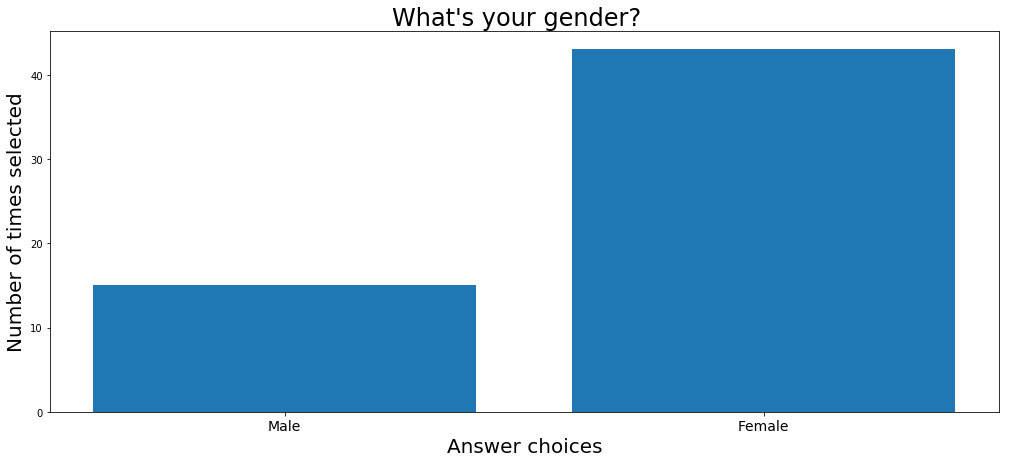

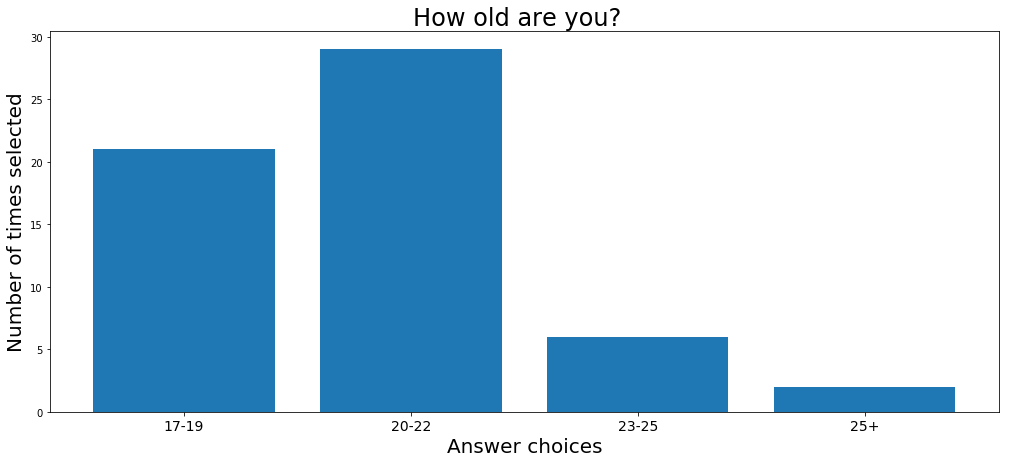

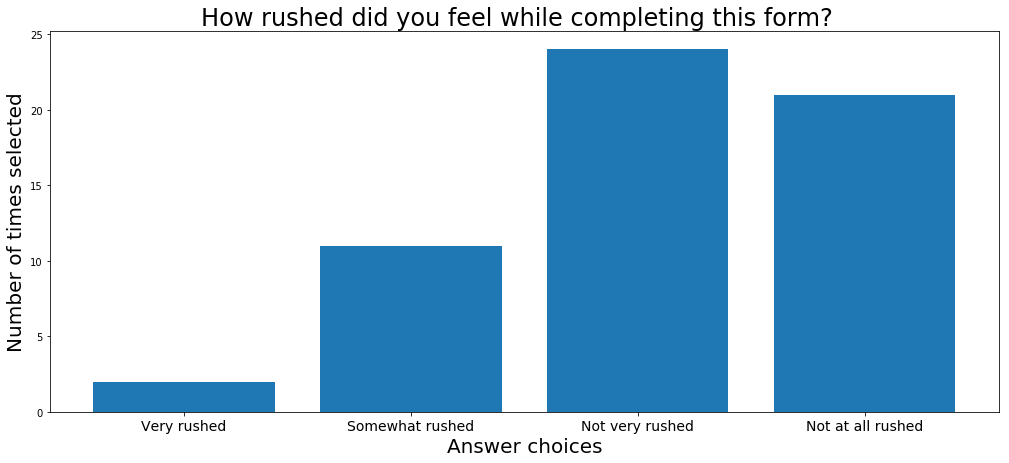

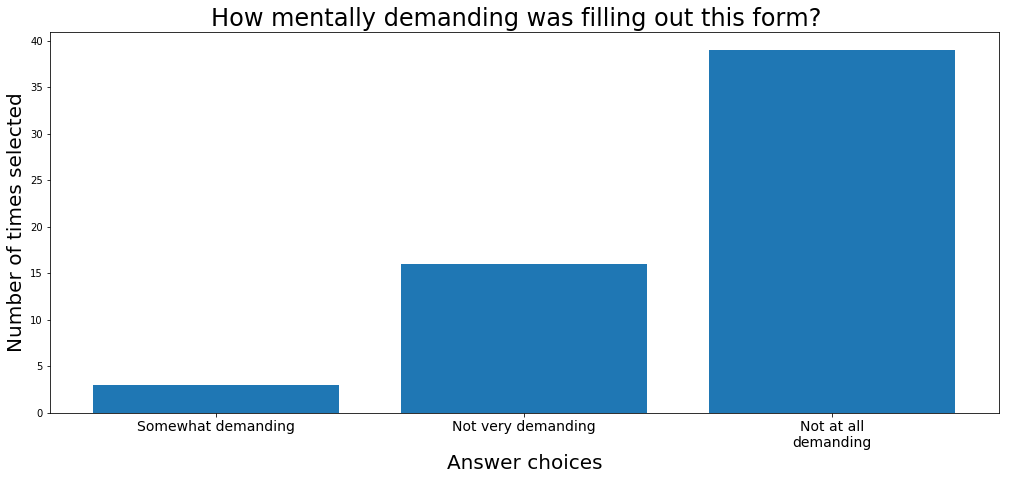

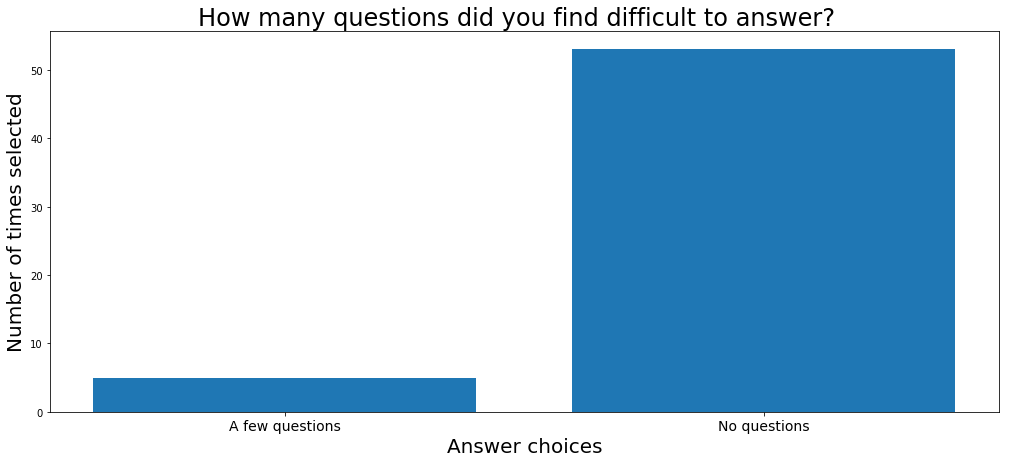

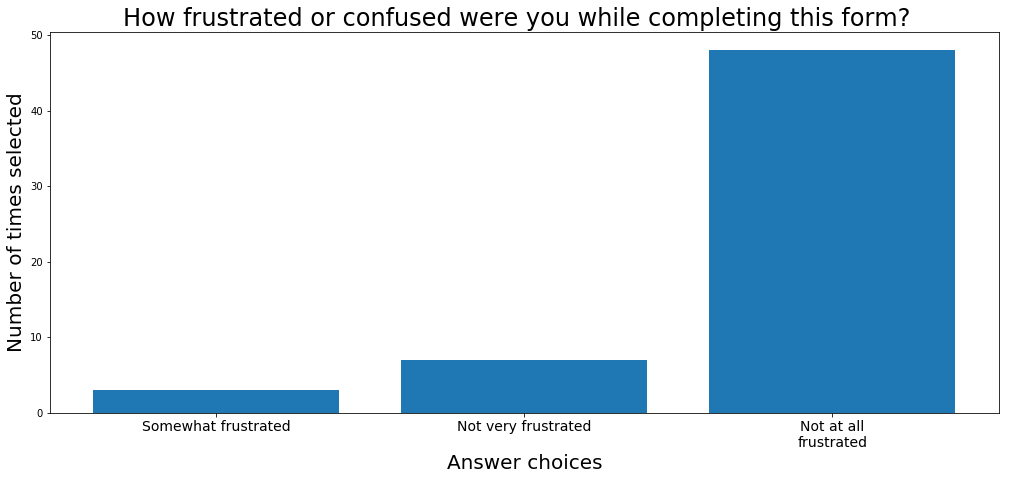

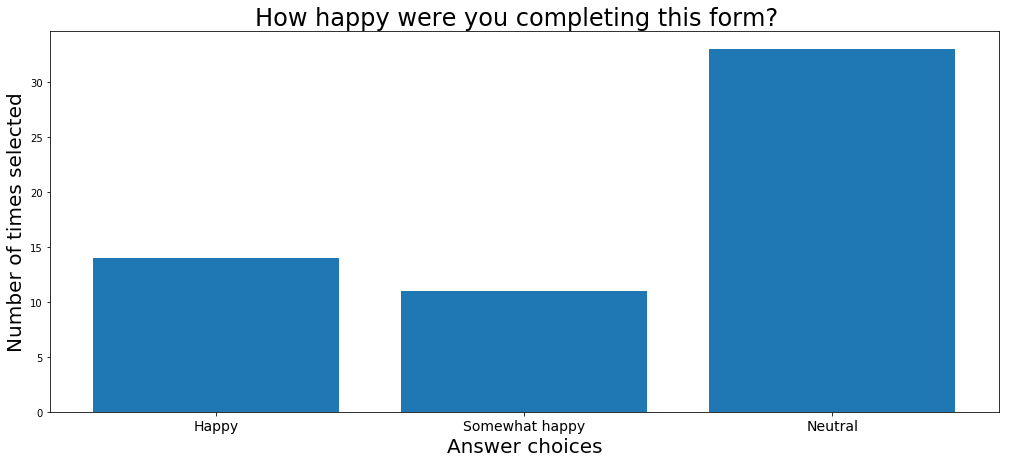

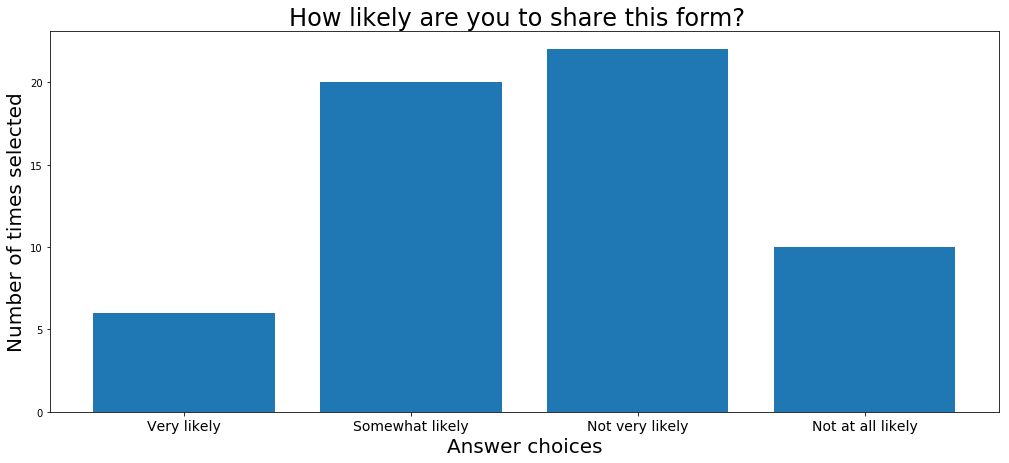

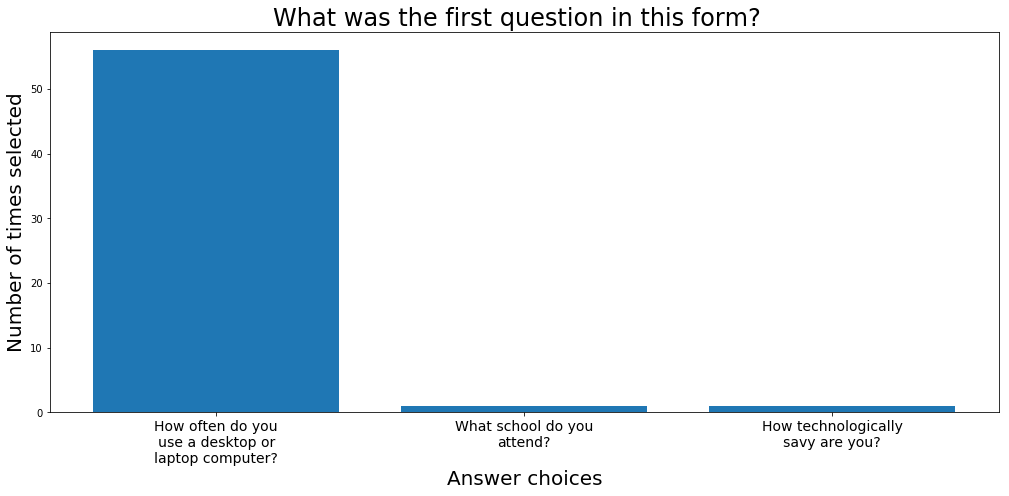

In [9]:
for r in range(len(responses)):
    # total numbers of times options were chosen
    totalled_answers = responses[r].values()
    
    # text of questions and answers
    title = list(survey_questions.keys())[r]
    choices = list(survey_questions.values())[r]
    
    selected_choices = []
    
    # remove the choices that were never selected
    for c in range(1, len(choices)+1):
        if c in sorted(responses[r].keys()):
            selected_choices.append(choices[c-1])
            
    # wrap words if too long
    selected_choices = [ '\n'.join(wrap(sc, 19)) for sc in selected_choices ]
            
    # logic for building bar chart
    y_pos = np.arange(len(selected_choices))
    plt.figure(figsize=(17,7))
    plt.bar(y_pos, totalled_answers, align='center')
    plt.xticks(y_pos, selected_choices, size=14)
    plt.xlabel('Answer choices', size=20)
    plt.ylabel('Number of times selected', size=20)
    plt.title(title, size=24)
    
    plt.show()

# clean the plot object when done
plt.clf()
plt.cla()
plt.close()

In [45]:
# dataset = [{'A':19, 'B':39, 'C':61, 'D':70},
#            {'A':34, 'B':68, 'C':32, 'D':38},
#            {'A':35, 'B':45, 'C':66, 'D':50},
#            {'A':23, 'B':23, 'C':21, 'D':16}]
#             
    
# data_orders = [['A', 'B', 'C', 'D'], 
#                ['B', 'A', 'C', 'D'], 
#                ['A', 'B', 'D', 'C'], 
#                ['B', 'A', 'C', 'D']]

def create_stacked_barchart(title, choices):
    colors = ["#26a69a","#3f51b5","#f44336","#ffeb3b"]
    names = sorted(dataset[0].keys())
    values = np.array([[data[name] for name in order] for data,order in zip(dataset, data_orders)])
    lefts = np.insert(np.cumsum(values, axis=1),0,0, axis=1)[:, :-1]
    orders = np.array(data_orders)
    bottoms = np.arange(len(data_orders))

    plt.figure(figsize=(15,10))

    for name, color in zip(names, colors):
        idx = np.where(orders == name)
        value = values[idx]
        left = lefts[idx]
        plt.bar(left=left, height=0.8, width=value, bottom=bottoms, 
                color=color, orientation="horizontal", label=name)
        
    plt.yticks(bottoms, choices, size=20)
    plt.xlabel('Number of times selected', size=20)
    plt.title(title, size=28)


    plt.legend(['Theme 1', 'Theme 2', 'Theme 3', 'Theme 4'], 
               loc="best", bbox_to_anchor=(1.0, 1.00), fontsize=20)
    plt.subplots_adjust(right=0.85)
    plt.show()

    # clean the plot object when done
    plt.clf()
    plt.cla()
    plt.close()

3_1  themeChosen
1    1              1
     4              1
2    1              2
     2              5
     3              2
     4              2
3    1              4
     2              7
     3              5
     4              8
4    1              4
     2              3
     3              7
     4              7
dtype: int64


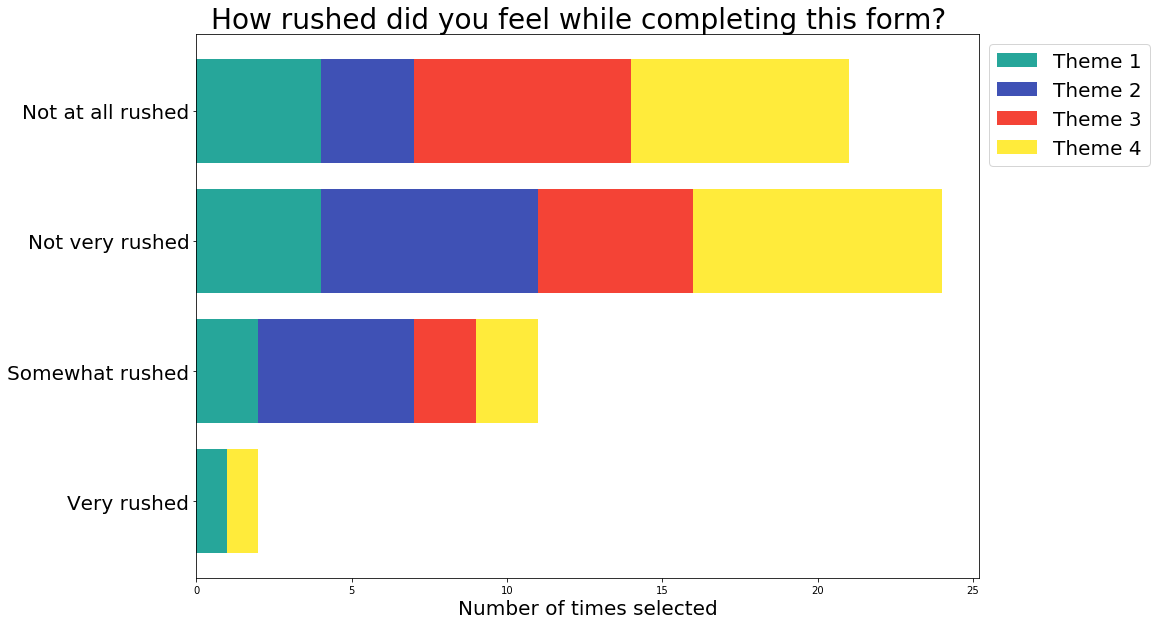

------------------------------------------------------------------------
3_2  themeChosen
2    2               1
     3               1
     4               1
3    1               3
     2               9
     3               1
     4               3
4    1               8
     2               5
     3              12
     4              14
dtype: int64


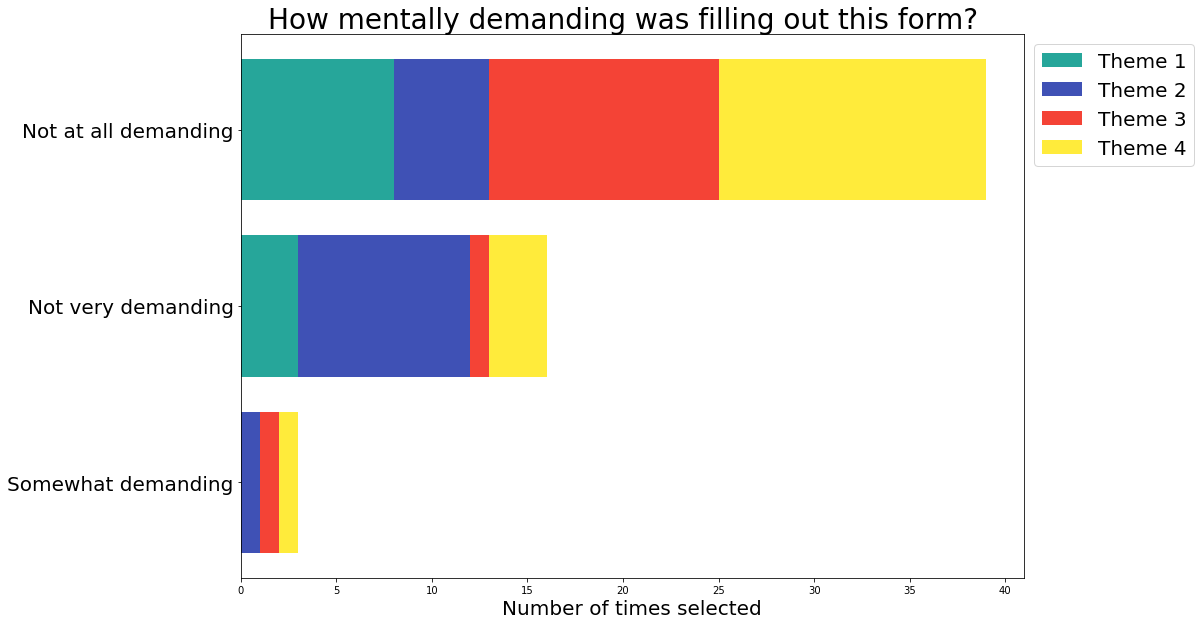

------------------------------------------------------------------------
3_3  themeChosen
2    1               1
     2               2
     3               1
     4               1
3    1              10
     2              13
     3              13
     4              17
dtype: int64


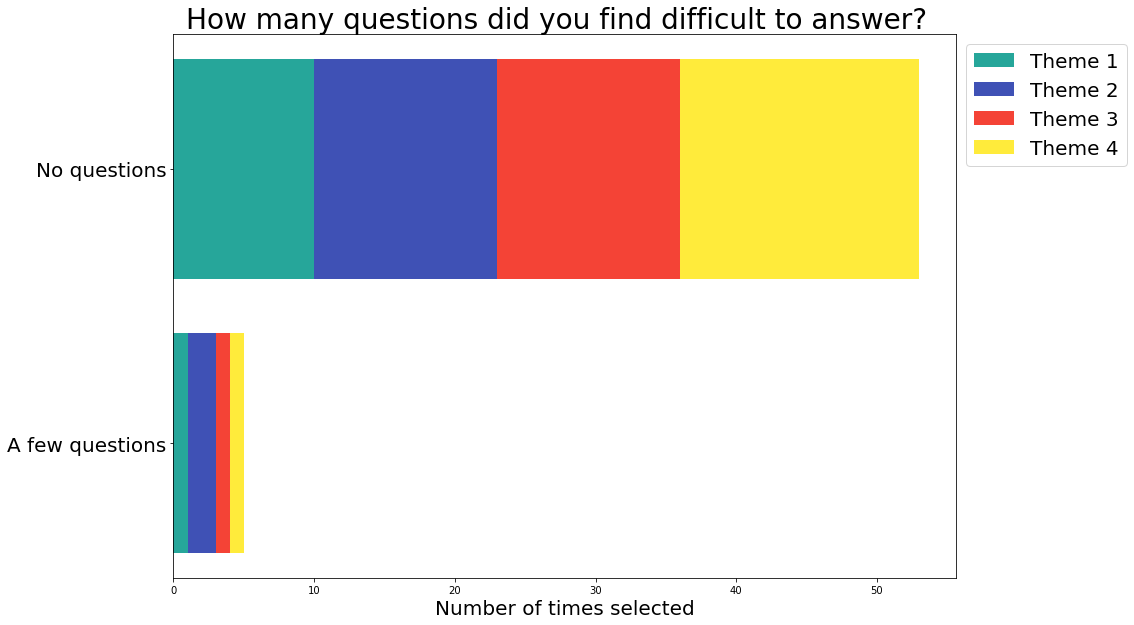

------------------------------------------------------------------------
3_4  themeChosen
2    2               1
     3               1
     4               1
3    1               2
     2               3
     4               2
4    1               9
     2              11
     3              13
     4              15
dtype: int64


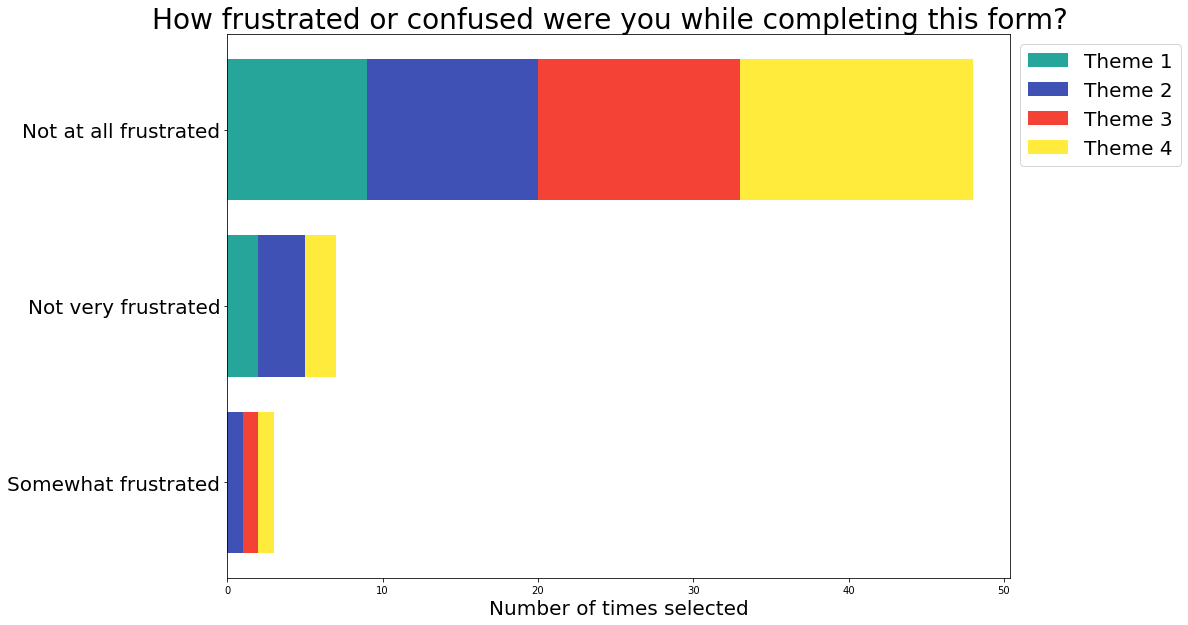

------------------------------------------------------------------------
3_5  themeChosen
1    2               3
     3               8
     4               3
2    1               4
     2               2
     3               1
     4               4
3    1               7
     2              10
     3               5
     4              11
dtype: int64


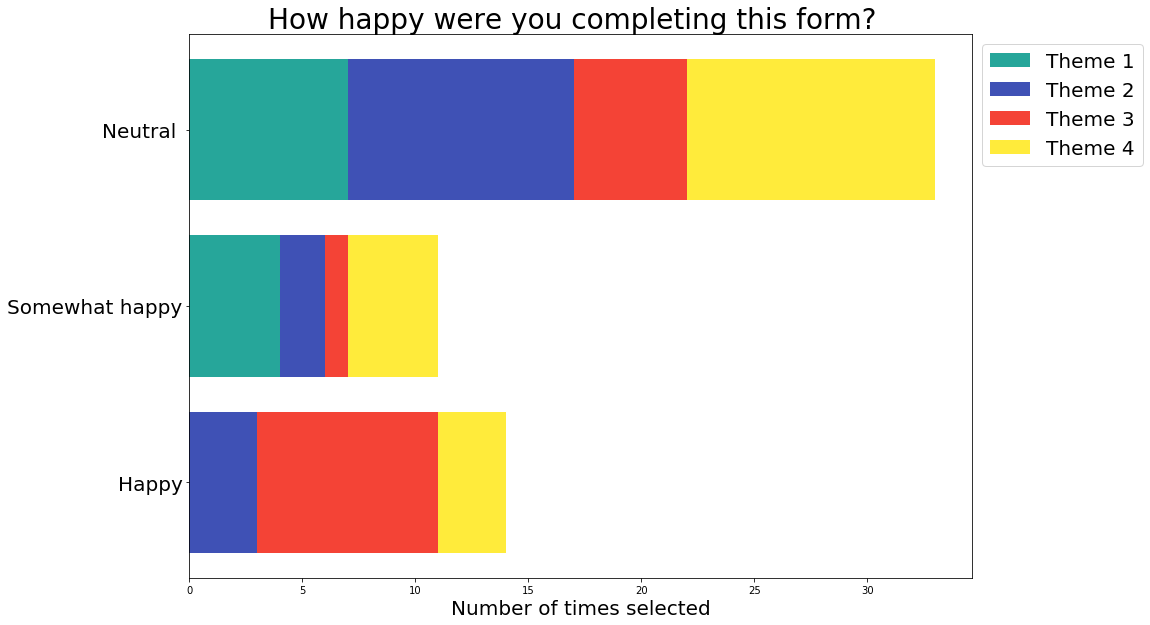

------------------------------------------------------------------------
3_6  themeChosen
1    1              1
     2              1
     3              3
     4              1
2    1              2
     2              7
     3              4
     4              7
3    1              6
     2              4
     3              6
     4              6
4    1              2
     2              3
     3              1
     4              4
dtype: int64


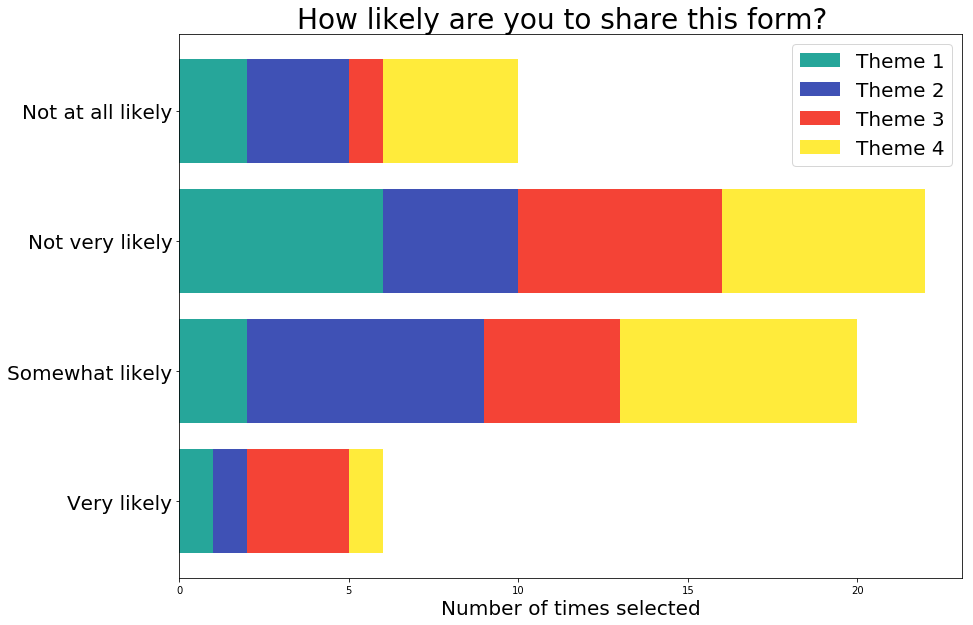

------------------------------------------------------------------------
3_7  themeChosen
1    1              11
     2              15
     3              14
     4              16
2    4               1
3    4               1
dtype: int64


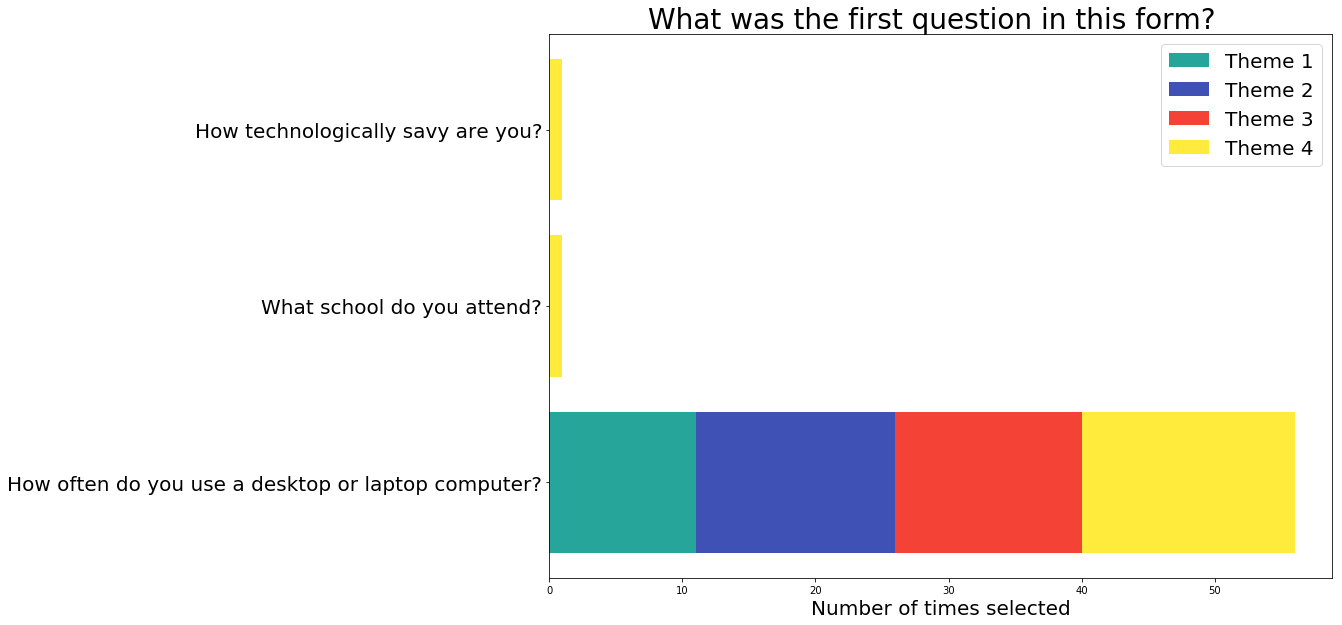

------------------------------------------------------------------------


In [73]:
# the questions on the last page
last_page_questions = ['3_' + str(i) for i in range(1,8)]

for cur_question in last_page_questions:
    # filter the dataframe for just the question and the theme
    cur_question_df = df[[cur_question, 'themeChosen']].groupby(
        [cur_question, 'themeChosen']).size()
#     print(cur_question_df)

    # grab the columns of the grouped dataframe above
    num_people = list(cur_question_df.as_matrix())
    answer_choice = []
    color_scheme = []
    
    for i, j in cur_question_df.index:
        answer_choice.append(i)
        color_scheme.append(j)

#     print("num_people", end="")
#     print(num_people)
#     print("answer_choice", end="")
#     print(answer_choice)
#     print("color_scheme", end="")
#     print(color_scheme)
    
        
    """
    order the data in a row of dictionaries such that:
        row = answer choice
        key = color scheme
        value = number of people w that color who made that choice
    """
    dataset = []
    for i in list(set(answer_choice)):
        cur_choice = {}
        j = 0
        while j < len(color_scheme):
            if answer_choice[j] == i:
                cur_choice[ color_scheme[j] ] = num_people[j]
            j += 1
        dataset.append(cur_choice)
#     print(dataset)
    
    # add missing keys to the dataset rows
    for row in dataset:
        for key in list(set(color_scheme)):
            if key not in row:
                row[key] = 0

                
#     print("new dataset: ", end="")
#     print(dataset)
    
    # determine the order in which to show colors
    data_orders = [list(dataset[i].keys()) for i in range(len(dataset))]
#     print(data_orders)
    
    # calculate yticks based off options
    cur_question_index = int(cur_question.split("_")[1]) - 8
    title = list(survey_questions.keys())[cur_question_index] 
    choices = list(survey_questions.values())[cur_question_index]
    
    # filter out choices that weren't selected
    choices = [choices[c] for c in range(len(choices))
              if c+1 in list(set(answer_choice))]

#     print("cur_question_index ", end="")
#     print(cur_question_index)
    
    create_stacked_barchart(title, choices)

    print("------------------------------------------------------------------------")